<a href="https://colab.research.google.com/github/kokolight/MetacriticProject/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataScience Project


## Creating the data set - Crawling and API


### Main problem -
* Gaming companies develop games for years and cannot predict if their game will be sucessfull or not.

### Data -
Metacritic -

Description: Games ranking and reviews

Website: https://www.metacritic.com/

RAWG - 
Website: https://rawg.io

### Web scraping

### Data we scrape:
- Name
- Release Date
- Metascore
- Userscore

### Data we get from API
- Singleplayer - True/False
- Multiplayer - True/False
- Achievements count
- Youtube related videos count
- Average playtime
- Is part of a series
- Publisher
- Developer
- Which consoles
- What genres
- Maturaty Rating

### Imports

In [541]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import threading
import re
import os.path
import math
from os import path
import json
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import preprocessing
from ast import literal_eval
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

### Variables

In [ ]:

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
}
RAWG_API_KEY = "2ae69e21c8c349e9816a0382283df150"
FILE_NAME = "video_games_ratings.csv"
BASE_URL = "https://www.metacritic.com"
BROWSE_URL = BASE_URL + "/browse/games/score/metascore/all/all/filtered?"
COLUMNS = [
    "game_name",
    "metascore",
    "userscore",
    "publisher",
    "developer",
    "release_date",
    "maturaty_rating",
    "singleplayer",
    "multiplayer",
    "onXbox",
    "onPC",
    "onPlaystation",
    "onSwitch",
    "onWii",
    "onMac",
    "onIOS",
    "onAndroid",
    "youtube_videos_count",
    "achievements_count",
    "ratings_count",
    "average_playtime",
    "game_series_count",
]

month_dict = {
    "January": "1",
    "February": "2",
    "March": "3",
    "April": "4",
    "May": "5",
    "June": "6",
    "July": "7",
    "August": "8",
    "September": "9",
    "October": "10",
    "November": "11",
    "December": "12",
}

 ### Function: Get all games data (by pages)


In [ ]:

def metacritic_games_data(start_page, end_page):
    index = 1
    game_records = []

    current_data = pd.read_csv(FILE_NAME, index_col=0) if path.exists(FILE_NAME) else pd.DataFrame(columns=COLUMNS)
    soup = BeautifulSoup(features="lxml")
    # Get all games in all pages
    for i in range(start_page, end_page):
        page_url = BROWSE_URL + "page={0}".format(i)
        req = requests.get(page_url, headers=HEADERS)
        soup.append(bs4.BeautifulSoup(req.text, "lxml"))

    trs = set(soup.select("tr"))
    spacers = set(soup.select("tr.spacer"))
    games = trs - spacers

    # For each game
    for game in games:
        game_name = game.select("h3")[0].text
        # Already exists
        if (not current_data.empty) and (game_name in current_data["game_name"].values):
            print(f"Already in dataframe - {game_name}")
            index = index + 1
            continue
        metascore = game.select("div.metascore_w.game")[0].text
        userscore = game.select("div.metascore_w.user.game")[0].text
        date = game.select("div.clamp-details")[0].find_all("span")[2].text.replace(",", "")
        date_splitted = date.split(" ")
        release_date = "{day}-{month}-{year}".format(
            day=date_splitted[1], month=month_dict[date_splitted[0]], year=date_splitted[2]
        )
        game_href = game.find("a", class_="title", href=True)["href"]
        game_slug = re.findall(".*\/(.*)$", game_href)[0]

        print(f"Game: {game_name}")

        game_object = get_game_data(game_slug, game_name, metascore, userscore, release_date)
        if len(game_object):
            game_records.append(game_object)
        else:
            print(f"Couldn't get game details: {game_name}")

        print("Progress: {:.2f}%".format((index / len(games)) * 100))
        index = index + 1
    
    new_data = pd.DataFrame(game_records)

    if not new_data.empty:
        current_data = current_data.append(new_data, ignore_index=True)
        current_data.to_csv("./video_games_ratings.csv", mode="w")
    return current_data

### Function: Get single game data

In [ ]:
def get_game_data(game_slug, game_name, metascore, userscore, release_date):
    rawg_details = get_game_rawg_details(game_slug)
    if len(rawg_details) == 0:
        return []

    return {
        "game_name": game_name,
        "release_date": release_date,
        "metascore": metascore,
        "userscore": userscore,
        "publisher": rawg_details["publisher"],
        "developer": rawg_details["developer"],
        "maturaty_rating": rawg_details["maturaty_rating"],
        "average_playtime": rawg_details["avg_playtime"],
        "achievements_count": rawg_details["achievements_count"],
        "youtube_videos_count": rawg_details["youtube_videos_count"],
        "singleplayer": rawg_details["singleplayer"],
        "multiplayer": rawg_details["multiplayer"],
        "onXbox": rawg_details["onXbox"],
        "onPC": rawg_details["onPC"],
        "onPlaystation": rawg_details["onPlaystation"],
        "onSwitch": rawg_details["onSwitch"],
        "onMac": rawg_details["onMac"],
        "onIOS": rawg_details["onIOS"],
        "onAndroid": rawg_details["onAndroid"],
        "ratings_count": rawg_details["ratings_count"],
        "genres": rawg_details["genres"],
        "game_series_count": rawg_details["game_series_count"],
    }

### Get game additional data from RAWG

In [ ]:
def get_game_rawg_details(game_name):
    try:
        RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
        data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Check if not redirected to another page
        while "redirect" in data:
            game_name = data["slug"]
            RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
            data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Not found
        if "detail" in data:
            return []
        if len(data):
            game_details = {
                "achievements_count": data["parent_achievements_count"],
                "avg_playtime": data["playtime"],
                "youtube_videos_count": data["youtube_count"],
                "singleplayer": False,
                "multiplayer": False,
                "game_series_count": data["game_series_count"],
                "maturaty_rating": data["esrb_rating"]["name"][0] if data["esrb_rating"] else None,
                "onXbox": False,
                "onPC": False,
                "onPlaystation": False,
                "onSwitch": False,
                "onWii": False,
                "onMac": False,
                "onIOS": False,
                "onAndroid": False,
                "genres": [],
                "platforms_count": len(data["platforms"]),
                "publisher": data["publishers"][0]["name"] if len(data["publishers"]) else None,
                "developer": data["developers"][0]["name"] if len(data["developers"]) else None,
                "ratings_count": data["ratings_count"],
            }
            for tag in data["tags"]:
                if tag["slug"] == "singleplayer":
                    game_details["singleplayer"] = True
                if tag["slug"] == "multiplayer":
                    game_details["multiplayer"] = True
            for platform in data["platforms"]:
                if bool(re.match("playstation", platform["platform"]["slug"])):
                    game_details["onPlastation"] = True
                if bool(re.match("xbox", platform["platform"]["slug"])):
                    game_details["onXbox"] = True
                if bool(re.match("pc", platform["platform"]["slug"])):
                    game_details["onPC"] = True
                if bool(re.match("switch", platform["platform"]["slug"])):
                    game_details["onSwitch"] = True
                if bool(re.match("macos", platform["platform"]["slug"])):
                    game_details["onMac"] = True
                if bool(re.match("ios", platform["platform"]["slug"])):
                    game_details["onIOS"] = True
                if bool(re.match("android", platform["platform"]["slug"])):
                    game_details["onAndroid"] = True
            for genre in data["genres"]:
                game_details["genres"].append(genre["slug"])
            return game_details
        else:
            print(f"{game_name} is not available!")
            return []
    except json.decoder.JSONDecodeError:
        print("There was a problem while decoding object...")
        return []


### Main - Retrieveing all the data

In [ ]:
df = metacritic_games_data(100, 150)
print(df)

# Exploring the data

In [323]:
def load_csv(filename):
    return pd.read_csv(filename, parse_dates=['release_date'])

def outlier_detection_iqr(df):
    df2 = df.copy()
    numeric_cols = df2.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        df2.loc[(df2[col] < Q1 - 1.5*IQR) | (df2[col] > Q3 + 1.5*IQR ),col] = np.nan
    return df2

def get_first_element(array):
    return array[0] if array else "None"

def get_frequent_elements(df, col_name, num_top_elements):
    return df[col_name].value_counts().head(num_top_elements)

,game_name,metascore,userscore,publisher,developer,release_date,maturity_rating,singleplayer,multiplayer,onXbox,...,onIOS,onAndroid,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,onMac,onWii,genres
0,FIFA 14,87,6.3,Electronic Arts,Electronic Arts Canada,2013-12-11,M,False,False,True,...,True,True,1000000,106,326,35,28,False,True,['sports']
1,The Sims,83,7.6,Electronic Arts,Maxis,2003-12-01,T,False,False,True,...,False,False,1000000,0,280,12,7,False,False,['simulation']
2,Tatsunoko vs. Capcom: Ultimate All-Stars,85,8.6,Capcom,8ing,2010-01-26,NaN,False,False,False,...,False,False,0,0,11,0,0,False,True,[]
3,Mario & Luigi: Partners in Time,86,8.5,Nintendo,AlphaDream,2005-11-28,E,False,False,False,...,False,False,897092,0,53,6,0,False,True,['role-playing-games-rpg']
4,Skylanders Swap Force,89,6.1,Activison,Vicarious Visions,2013-10-13,E,False,False,True,...,False,False,780741,41,17,0,0,False,True,"['action', 'adventure', 'platformer']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592,Knights Contract,51,6.9,Bandai Namco Entertainment,Game Republic,2011-02-22,M,False,False,True,...,False,False,0,50,11,0,0,False,False,"['action', 'adventure']"
12593,Duke Nukem Forever,49,4.5,2K Games,Aspyr Media,2011-06-14,NaN,True,True,True,...,True,False,686616,66,404,3,11,True,False,"['action', 'shooter']"
12594,Gomo,50,4.8,Daedalic Entertainment,Daedalic Entertainment,2013-06-12,E,True,False,False,...,True,False,27735,0,36,3,0,True,False,"['adventure', 'indie', 'puzzle']"
12595,Food Network: Cook or Be Cooked,53,6.8,BANDAI NAMCO Entertainment America,Red Fly Studio,2009-03-11,NaN,False,False,False,...,False,False,0,0,0,0,0,False,True,[]


In [88]:
df.corr()

,metascore,userscore,singleplayer,multiplayer,onXbox,onPC,onPlaystation,onSwitch,onWiionMac,onIOS,onAndroid,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,onMac,onWii
metascore,1.000000,0.492687,0.052238,0.070158,0.055588,0.031808,NaN,0.095269,NaN,0.063181,0.059752,0.246985,0.072313,0.295670,0.124711,0.203745,0.083425,0.024411
userscore,0.492687,1.000000,-0.042983,-0.029029,-0.123401,-0.163537,NaN,-0.033905,NaN,-0.020013,-0.000346,0.039659,-0.091918,0.122280,0.036725,0.050352,-0.036523,0.063875
singleplayer,0.052238,-0.042983,1.000000,0.362520,0.176174,0.494559,NaN,0.225262,NaN,0.147982,0.105281,0.132975,0.175667,0.174729,-0.077604,-0.014307,0.361793,-0.125366
multiplayer,0.070158,-0.029029,0.362520,1.000000,0.161624,0.140481,NaN,-0.004108,NaN,-0.017974,0.015907,0.190747,0.189017,0.152947,0.015686,0.104827,0.038873,-0.048073
onXbox,0.055588,-0.123401,0.176174,0.161624,1.000000,0.163764,NaN,0.220749,NaN,0.047609,0.053635,0.273758,0.220513,0.244035,0.042884,0.100661,0.087959,0.007682
onPC,0.031808,-0.163537,0.494559,0.140481,0.163764,1.000000,NaN,0.194555,NaN,0.139940,0.099206,0.154972,0.189389,0.175115,-0.024595,-0.015001,0.329100,-0.159343
onPlaystation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onSwitch,0.095269,-0.033905,0.225262,-0.004108,0.220749,0.194555,NaN,1.000000,NaN,0.207745,0.159902,0.041022,0.082236,0.099653,-0.025099,-0.039757,0.255087,-0.040057
onWiionMac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onIOS,0.063181,-0.020013,0.147982,-0.017974,0.047609,0.139940,NaN,0.207745,NaN,1.000000,0.625450,0.082724,0.055743,0.091115,-0.021061,0.005185,0.337150,0.037238


In [324]:
def prepare_dataset(df):
    
  # Dealing with 'bad' data - duplicates and null values
        df2 = df.copy()
        df2 = df2.drop_duplicates(subset=['game_name'])

        # Dealing with missing userscore values
        df2 = df2.drop(df2[df2['userscore'] == 'tbd'].index)
        
        # Removing NaN values
        df2.dropna(subset=['publisher', 'developer', 'maturity_rating'], inplace=True)

        # Dealing with games that haven't been released yet
        today = pd.Timestamp('today')
        df2 = df2.drop(df2[df2['release_date'] > today].index)

        df2['userscore'] = df2['userscore'].astype(float)
        # Convert genres string to array
        df2['genres'] = df['genres'].apply(literal_eval)

        onMobile = df2['onIOS'] | df2['onAndroid']
        averageScore = df2['metascore'] + (df2['userscore']*10)
        # Making Boolean values to int
        df2['onXbox'] = df2['onXbox'].astype(int)
        df2['onPC'] = df2['onPC'].astype(int)
        df2['onPlaystation'] = df2['onPlaystation'].astype(int)
        df2['onSwitch'] = df2['onSwitch'].astype(int)
        df2['onWii'] = df2['onWii'].astype(int)
        df2['onMac'] = df2['onMac'].astype(int)
        df2['onIOS'] = df2['onIOS'].astype(int)
        df2['onAndroid'] = df2['onAndroid'].astype(int)
        df2['singleplayer'] = df2['singleplayer'].astype(int)
        df2['multiplayer'] = df2['multiplayer'].astype(int)
        df2['onMobile'] = onMobile.astype(int)
        df2['release_year'] = [date.year for date in df2['release_date']]
        df2['average_score'] = averageScore / 2
        df2['average_playtime'] = df2['average_playtime'].astype(float)
        df2.drop(columns=['release_date'], inplace=True)
        df2['genres'] = df2['genres'].apply(get_first_element)
        success_rates = []
        
        for index, row in df2.iterrows():
            if row['average_score'] <= 55.0 or row['average_playtime'] < 1.0:
                successRate = 0
            elif (row['average_score'] > 55.0) and (row['average_score'] <= 75.0) or (row['average_playtime'] >= 1.0 and row['average_playtime'] < 4.0): 
                successRate = 1
            elif (row['average_score'] > 75.0) or (row['average_playtime'] >= 4.0): 
                successRate = 2
                
            success_rates.append(successRate)
        
        df2['success_rate'] = success_rates
        # Reset indices
        df2 = df2.reset_index(drop=True)
        
        return df2

def prepare_dataset_for_ml(df):
    df2 = df.copy()
    df2.drop(columns=["game_name", "publisher", "developer"])
    
# Loading the data
df = load_csv("video_games_ratings2.csv")
# Drop first column
df = df.iloc[:, 1:]
df.drop(columns="onWiionMac", inplace=True)
df = prepare_dataset(df)
condition = df['average_playtime'] == 0

df.groupby("average_playtime")['game_name'].count()

# avg_playtime = df['average_playtime'].mean()
# df.loc[condition, 'average_playtime'] = avg_playtime
# df['average_playtime'] = df['average_playtime'].astype(int)



average_playtime
0.0      1232
1.0       507
2.0       375
3.0       391
4.0       269
         ... 
156.0       1
178.0       1
211.0       1
226.0       1
239.0       1
Name: game_name, Length: 78, dtype: int64

In [239]:
df[df['average_playtime'] == 0]

,game_name,metascore,userscore,publisher,developer,maturity_rating,singleplayer,multiplayer,onXbox,onPC,...,ratings_count,average_playtime,game_series_count,onMac,onWii,genres,onMobile,release_year,average_score,success_rate
3,Skylanders Swap Force,89,6.1,Activison,Vicarious Visions,E,0,0,1,0,...,17,0.0,0,0,1,"[action, adventure, platformer]",0,2013,75.0,-1
12,Madden NFL 06,86,8.0,Electronic Arts,Electronic Arts Tiburon,E,1,1,1,1,...,13,0.0,0,0,0,[sports],0,2005,83.0,-1
16,MotorStorm,84,7.4,Sony Computer Entertainment,Sony Interactive Entertainment,T,0,0,0,0,...,25,0.0,0,0,0,"[racing, arcade]",0,2007,79.0,-1
26,Persona 2: Eternal Punishment,83,4.4,Atlus,Atlus,T,1,0,0,0,...,30,0.0,8,0,0,[role-playing-games-rpg],0,2000,63.5,-1
31,NCAA Football 11,86,7.2,Electronic Arts,Electronic Arts Tiburon,E,0,0,1,0,...,14,0.0,0,0,0,[sports],0,2010,79.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,Trinity: Souls of Zill O'll,55,7.9,Koei,KOEI TECMO America,T,0,0,0,0,...,2,0.0,0,0,0,"[action, role-playing-games-rpg]",0,2011,67.0,-1
3570,Hero of Sparta,58,6.4,Gameloft,Gameloft,M,0,0,0,0,...,2,0.0,0,0,0,"[action, adventure, role-playing-games-rpg]",1,2009,61.0,-1
3571,Winter Stars,46,6.5,Deep Silver,49Games,E,0,0,1,0,...,5,0.0,0,0,0,[sports],0,2011,55.5,-1
3572,Dash of Destruction,53,6.2,Microsoft Game Studios,NinjaBee,E,1,0,1,0,...,54,0.0,0,0,0,"[action, racing]",0,2008,57.5,-1


In [167]:
# Exploring the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579 entries, 0 to 3578
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_name             3579 non-null   object 
 1   metascore             3579 non-null   int64  
 2   userscore             3579 non-null   float64
 3   publisher             3579 non-null   object 
 4   developer             3579 non-null   object 
 5   maturity_rating       3579 non-null   object 
 6   singleplayer          3579 non-null   int32  
 7   multiplayer           3579 non-null   int32  
 8   onXbox                3579 non-null   int32  
 9   onPC                  3579 non-null   int32  
 10  onPlaystation         3579 non-null   int32  
 11  onSwitch              3579 non-null   int32  
 12  onIOS                 3579 non-null   int32  
 13  onAndroid             3579 non-null   int32  
 14  youtube_videos_count  3579 non-null   int64  
 15  achievements_count   

In [ ]:
df

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Userscore')

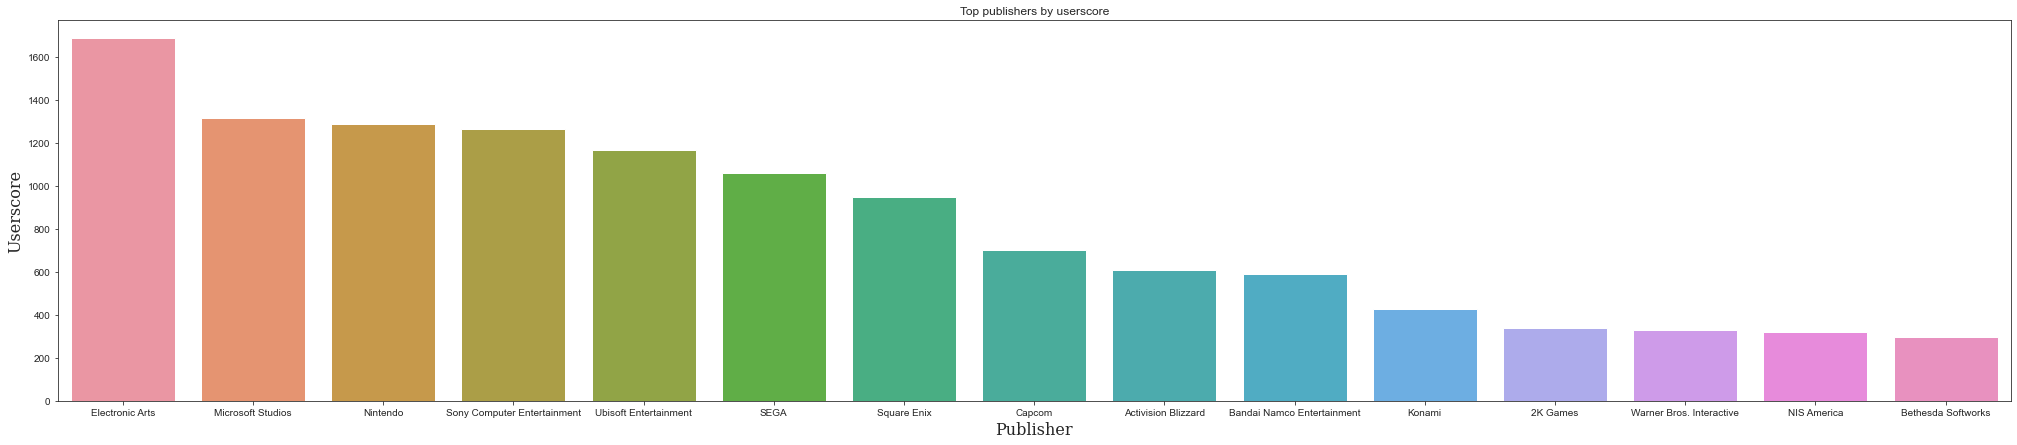

In [129]:
def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type, ax=axis)

publishers = get_frequent_publishers(df, 'publisher', 10)
fig, axes = plt.subplots(1,1, figsize=(35,7))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
publishers_score = df.groupby("publisher")['userscore'].sum().sort_values(ascending=False).head(15)
ax = sns.barplot(publishers_score.index, publishers_score)
ax.set_title("Top publishers by userscore")
ax.set_xlabel("Publisher", font)
ax.set_ylabel("Userscore", font)


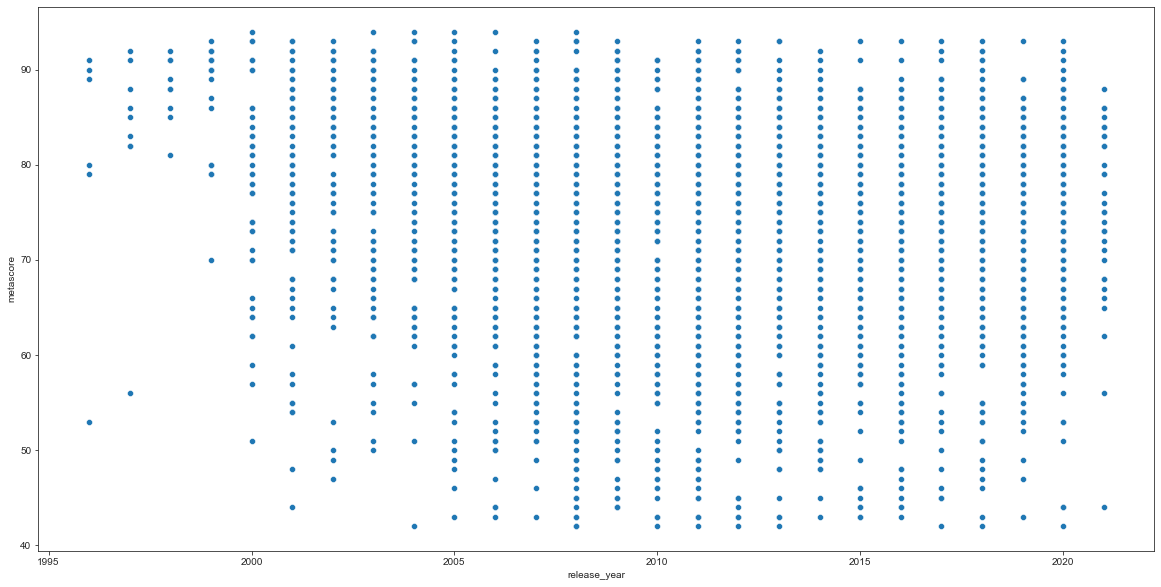

In [285]:
# years = get_frequent_elements(df, 'release_year', 10)
fig, axes = plt.subplots(1,1, figsize=(20,10))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
# success_rate = df.groupby("release_year").groupby('success_rate').count()
# success_rate
ax = sns.scatterplot(data=df, x='release_year', y="metascore")
# ax = sns.barplot(x="onXbox", y="onPC", hue="onPlaystation", data=df)
# ax.set_title("Top years by userscore")
# ax.set_xlabel("Years", font)
# ax.set_ylabel("Userscore", font)


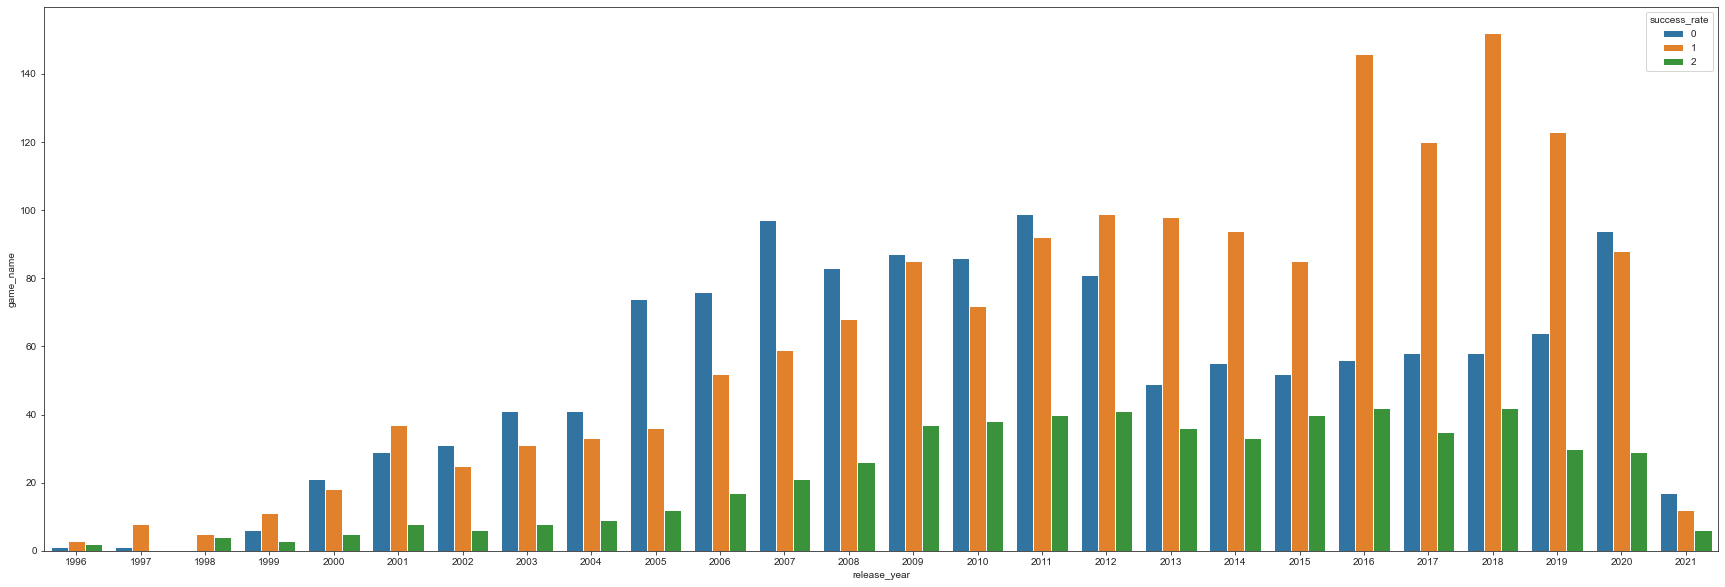

In [286]:
fig, axes = plt.subplots(1,1, figsize=(30,10))
success_rate_count = df.groupby(['release_year' , 'success_rate']).count().reset_index()
success_rate_count.loc[success_rate_count['release_year'] == 2000]['game_name']
ax = sns.barplot(data=success_rate_count, x='release_year', y = 'game_name', hue="success_rate")

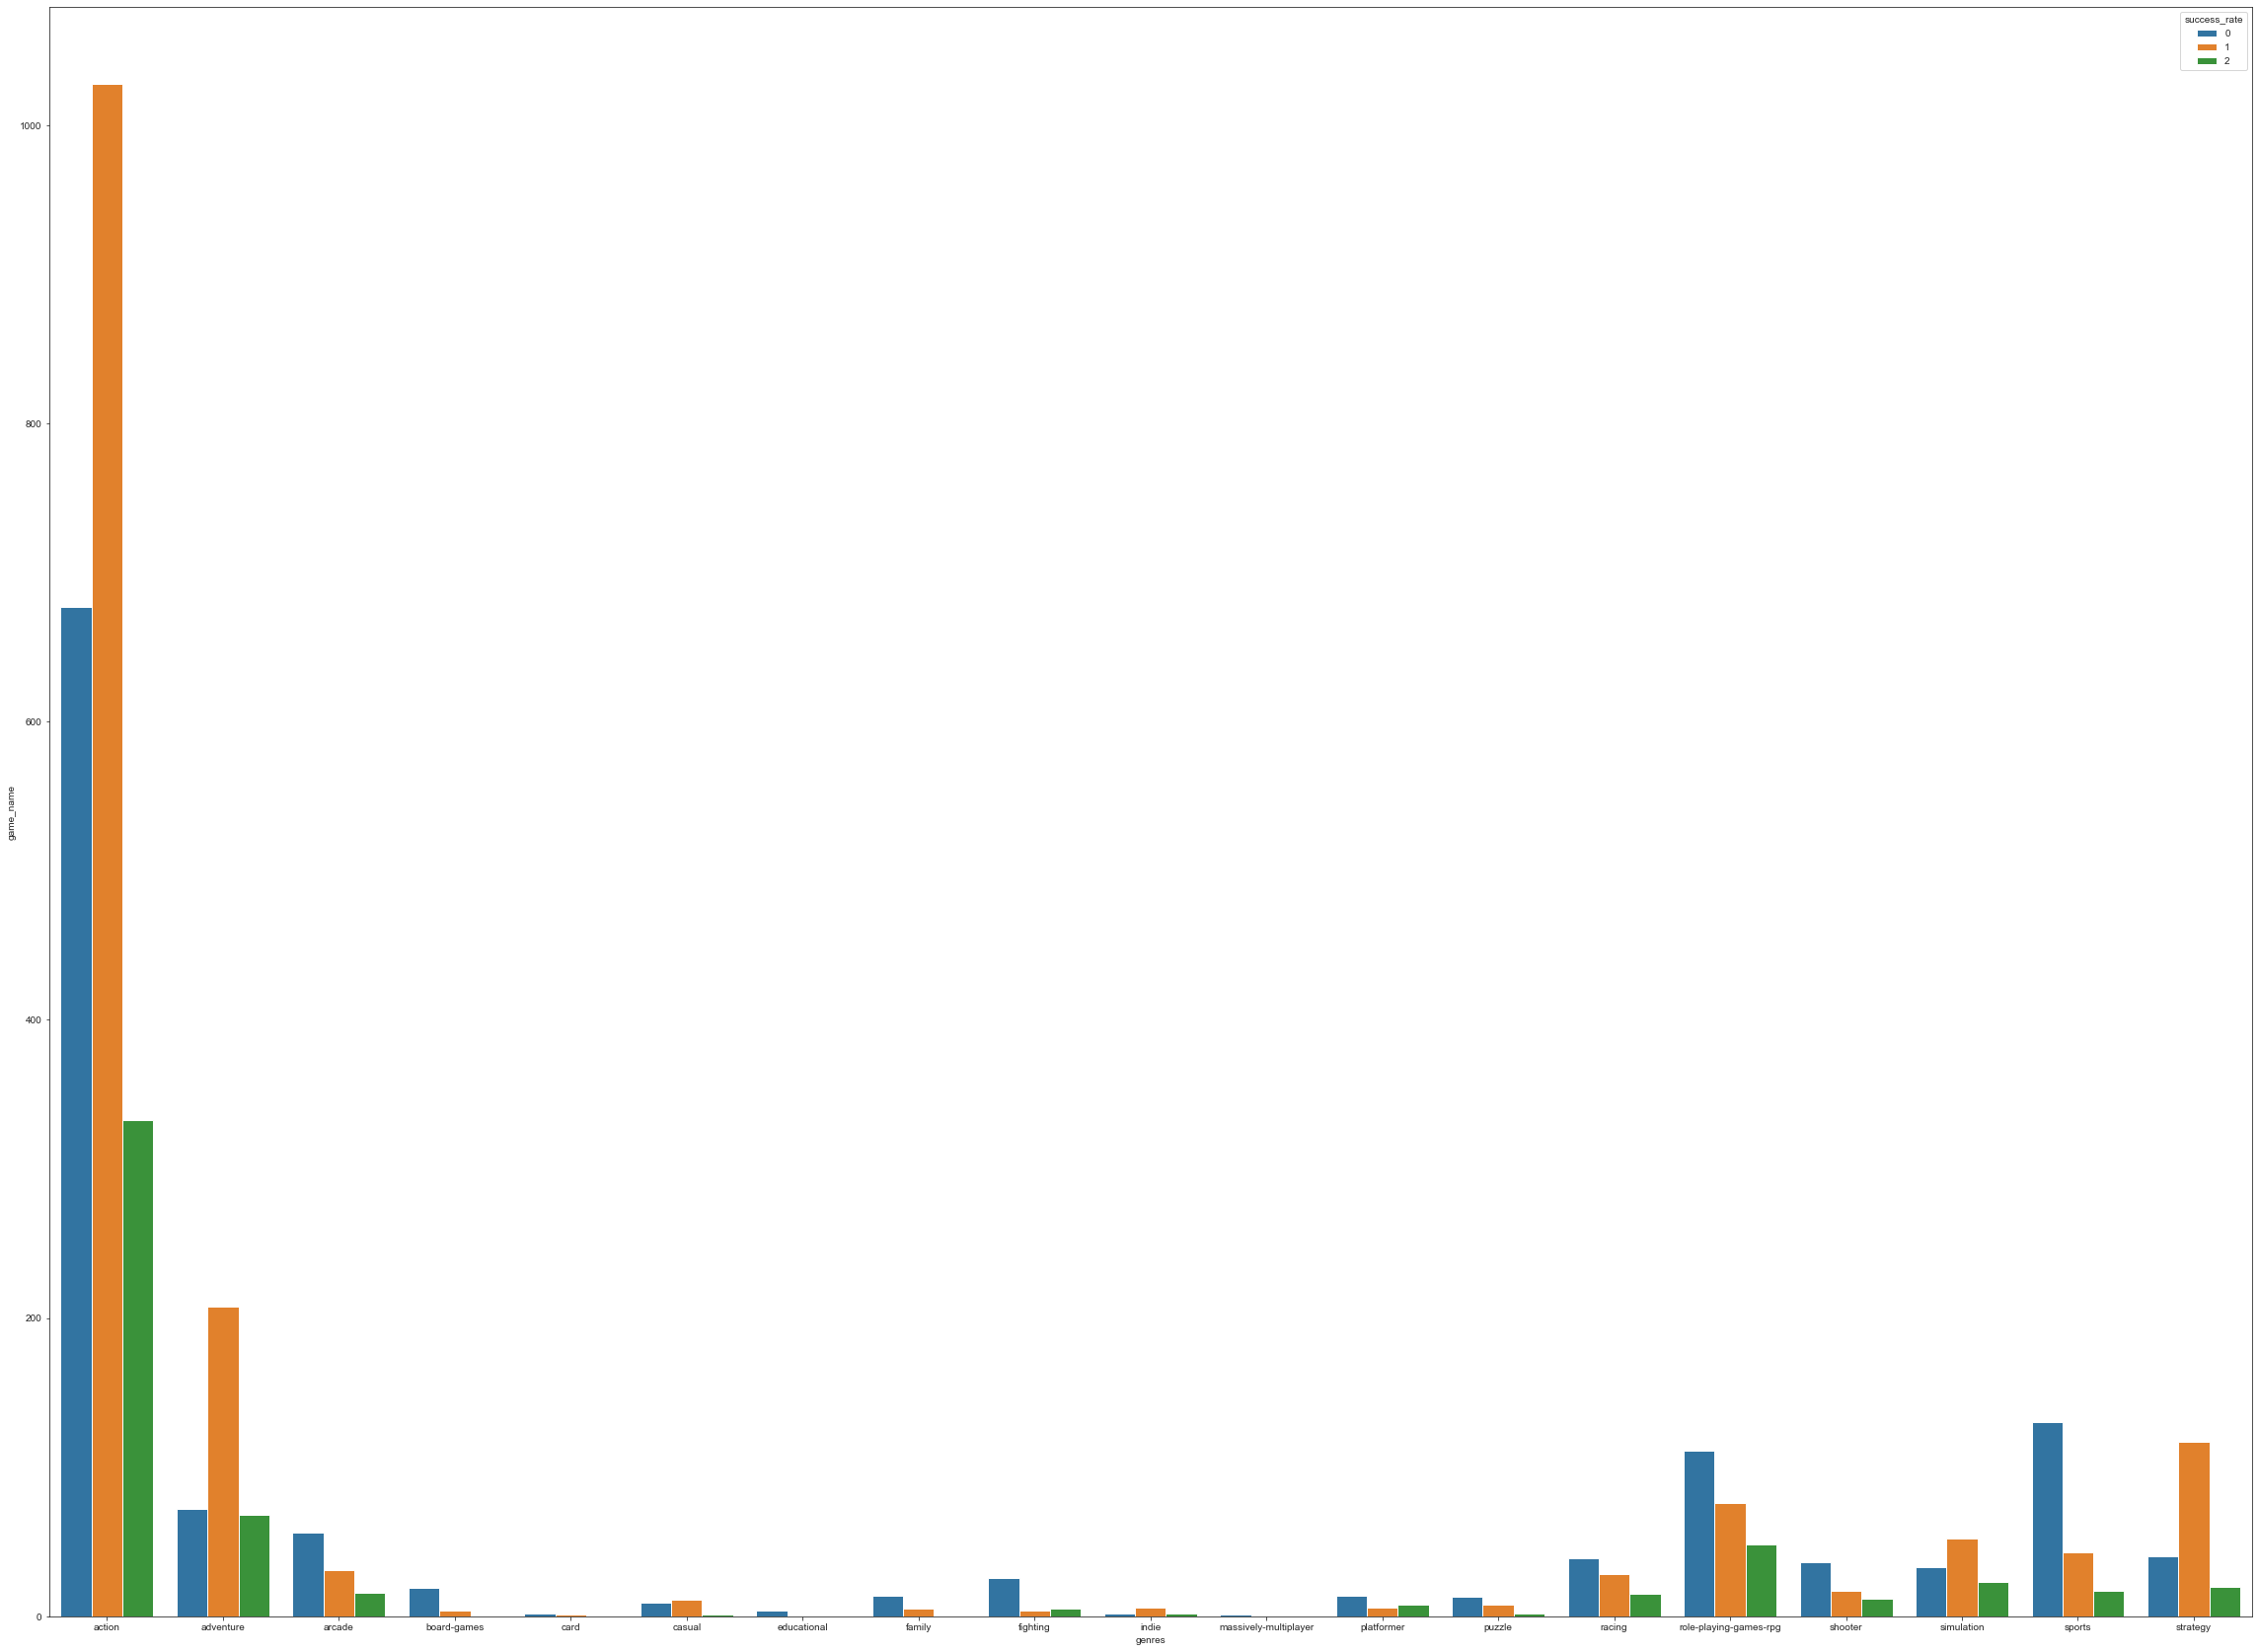

In [291]:
fig, axes = plt.subplots(1,1, figsize=(40,30))
genres_count = df.groupby(['genres' , 'success_rate']).count().reset_index()
genres_count.loc[genres_count['genres'] == 2000]['game_name']
ax = sns.barplot(data=genres_count, x='genres', y = 'game_name', hue="success_rate")

([<matplotlib.patches.Wedge at 0x20bcddcabb0>,
 [Text(1.0867501255993324, 0.1702179911461641, 'adventure'),
  Text(0.9769536454069181, 0.5055309829536998, 'sports'),
  Text(0.8129863369393876, 0.7409812520906833, 'action'),
  Text(0.6915393280211749, 0.8554375241945037, 'shooter'),
  Text(0.4450274292395154, 1.0059575474265643, 'None'),
  Text(0.15159228961827764, 1.089504372514534, 'arcade'),
  Text(0.05067416299711615, 1.098832166076577, 'board-games'),
  Text(0.0014483625036293937, 1.0999990464750677, 'strategy'),
  Text(-0.026550400514929923, 1.0996795334243958, 'role-playing-games-rpg'),
  Text(-0.037167102184302185, 1.099371914556317, 'racing'),
  Text(-0.08055236818986891, 1.097046633456848, 'family'),
  Text(-0.13244286293239332, 1.091997659364832, 'educational'),
  Text(-0.15446077617214107, 1.089101404197194, 'fighting'),
  Text(-0.17832159117889076, 1.08544986531826, 'puzzle'),
  Text(-0.20114733059246792, 1.081452611719776, 'simulation'),
  Text(-0.22577416198525554, 1.0765

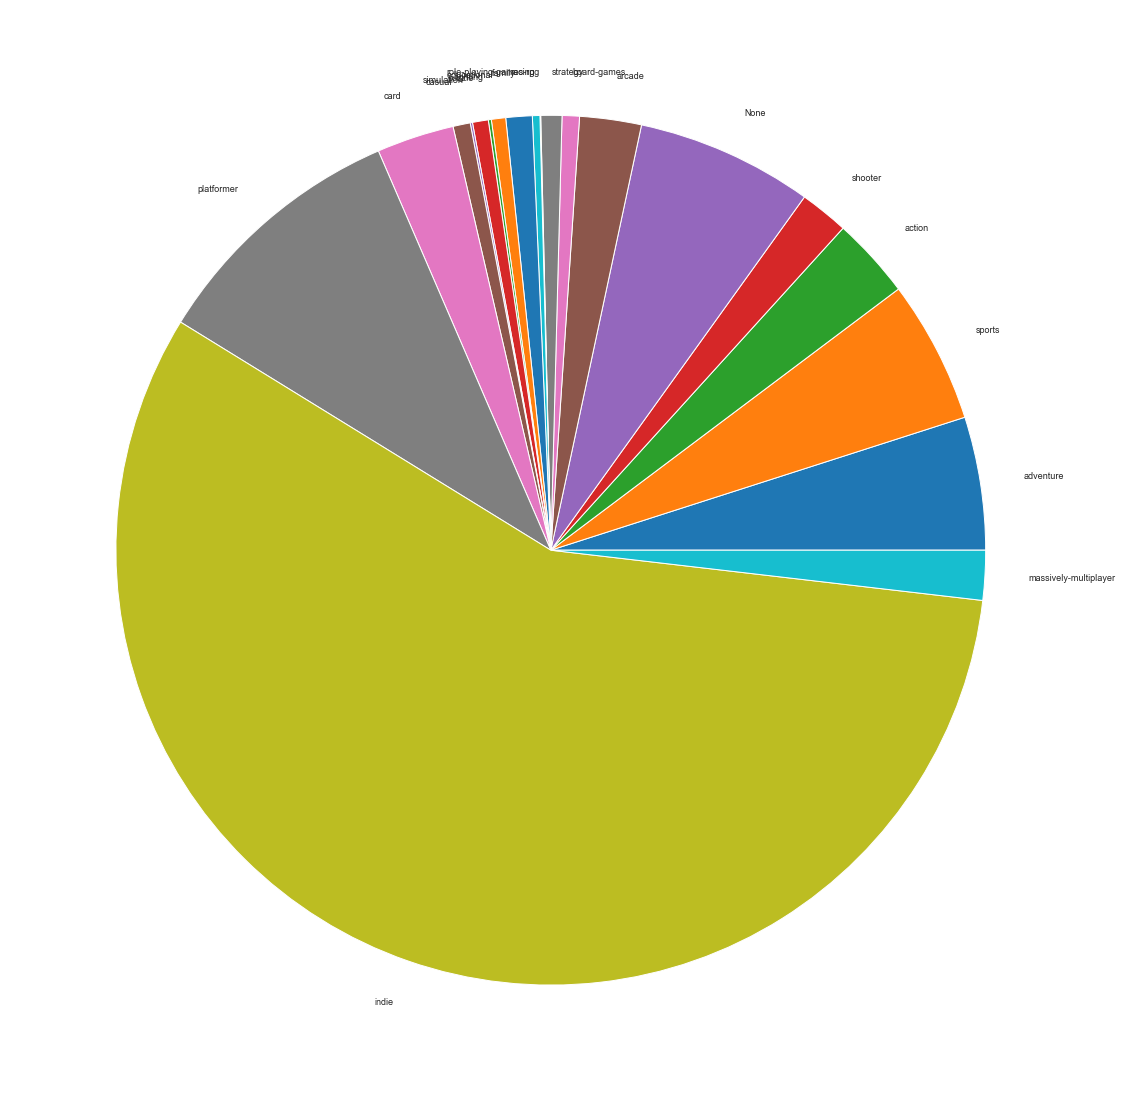

In [408]:
genres_count = df.groupby('genres')['genres'].count().sort_index(ascending=False).tolist()
genres_count
labels = df['genres'].sort_index(ascending=False).unique().tolist()
fig, axes = plt.subplots(figsize=(20,20))
plt.rcParams['font.size'] = 9.0
axes.pie(genres_count, labels=labels)
# publisher = df.groupby(['publisher' , 'success_rate']).count().reset_index()

In [406]:
genres_count = df.groupby('genres')['genres'].count().values.tolist()
genres_names = df.groupby('genres')['genres'].count().index.tolist()
print(genres_count, genres_names)
# df[df['genres'] == 'None']
# df['genres'].unique().tolist()

[66, 2038, 348, 103, 23, 3, 21, 4, 19, 35, 10, 1, 28, 23, 82, 235, 65, 108, 190, 177] ['None', 'action', 'adventure', 'arcade', 'board-games', 'card', 'casual', 'educational', 'family', 'fighting', 'indie', 'massively-multiplayer', 'platformer', 'puzzle', 'racing', 'role-playing-games-rpg', 'shooter', 'simulation', 'sports', 'strategy']


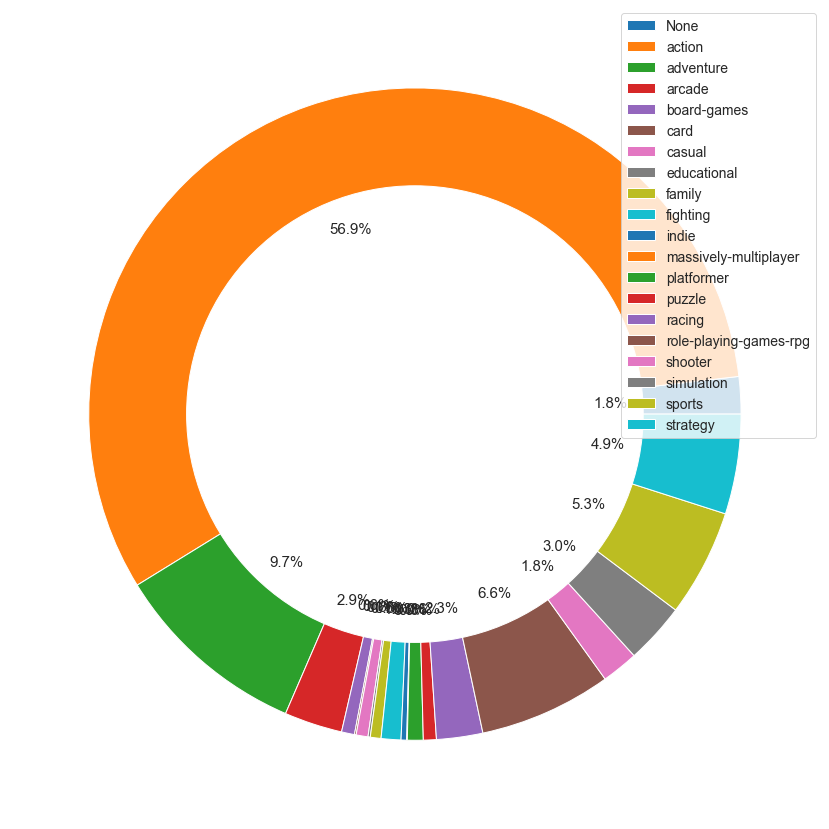

In [449]:
# library
import matplotlib.pyplot as plt
# create data
genres_count = df.groupby('genres')['genres'].count().values.tolist()
genres_names = df.groupby('genres')['genres'].count().index.tolist()

fig, axes = plt.subplots(figsize=(15,15))
# Create a pieplot
axes.pie(genres_count, autopct='%1.1f%%')
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
axes.legend(genres_names,fontsize=14, loc='upper right')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show(theme)

([<matplotlib.patches.Wedge at 0x20bc963d670>,
 [Text(1.1406469440513394, 0.6236381555247732, 'High'),
  Text(-0.847798360485281, 0.700883685042297, 'Medium'),
  Text(0.407646769601606, -1.0216771071299264, 'Low')])

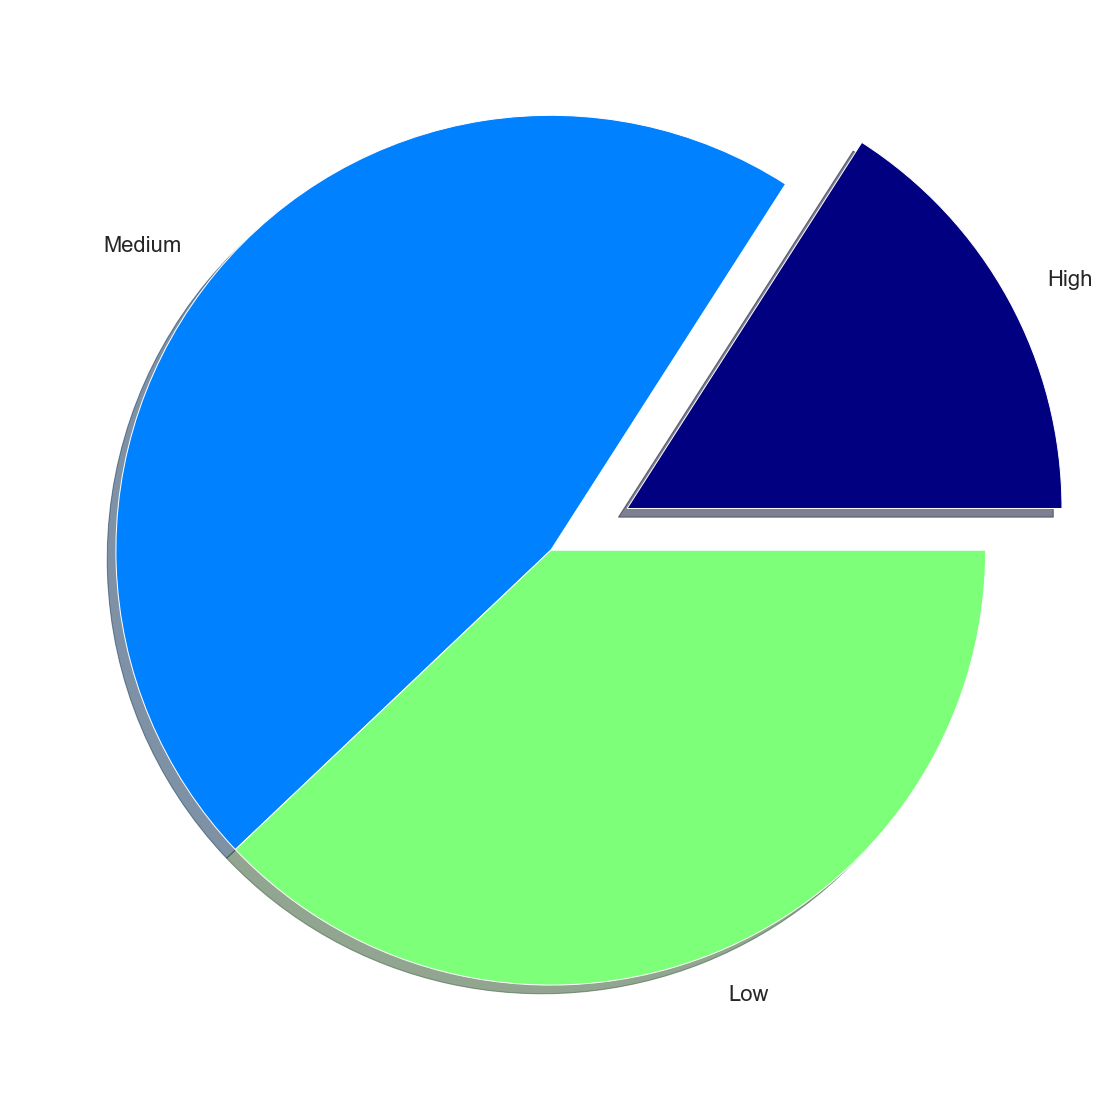

In [456]:
labels = ['High', 'Medium', 'Low']
success_rate_count = df.groupby('success_rate')['success_rate'].count().sort_index(ascending=False)
fig, axes = plt.subplots(figsize=(20,20))
theme = plt.get_cmap('jet')
explode = [0.2, 0, 0]
axes.set_prop_cycle("color", [theme(1. * i / len(sizes))
                             for i in range(len(sizes))])
plt.rcParams['font.size'] = 22
axes.pie(success_rate_count, labels=labels, explode=explode, shadow=True)

In [461]:
def get_highly_correlated_cols(df):
    correlations , tuple_arr = [],[]
    col_count = len(df.columns)
    for i in range(col_count):
        for j in range(i+1, col_count):
            pearson=df[df.columns[i]].corr(df[df.columns[j]])
            if pearson >=0.5:
                correlations.append(pearson)
                tuple_arr.append([i,j])
    return correlations, tuple_arr
df
correlations_cols = ['singleplayer', 'multiplayer', 'onXbox', 'onPC', 'ratings_count',
                     'average_playtime', 'onMac', 'onPlaystation', 'onWii', 'release_year', 'success_rate', 'average_score']
correlations, tuple_arr = get_highly_correlated_cols(df[correlations_cols])
print(correlations)
print(tuple_arr)

[0.666683718018754]
[[0, 3]]


In [423]:

def cross_tabulation(df, col_name, other_col_name):
    return pd.crosstab(df[col_name], df[other_col_name], normalize='index')

def plot_cross_tabulation(df, col_names, other_col_name):
    fig=plt.figure(figsize=(20,5))
    for i in range(len(col_names)):
        subplot=fig.add_subplot(1, 5, i+1)
        sr=cross_tabulation(df,col_names[i], other_col_name)
        one_dim_plot(sr, 'line' , subplot)
# df_crosstab = cross_tabulation(df, 'release_year', 'success_rate')
df_crosstab

# plot_cross_tabulation(df, ['metascore', 'userscore'], ['average_playtime'])

success_rate,0,1,2
release_year,,,
1996,0.166667,0.500000,0.333333
1997,0.111111,0.888889,0.000000
1998,0.000000,0.555556,0.444444
1999,0.300000,0.550000,0.150000
2000,0.477273,0.409091,0.113636
2001,0.391892,0.500000,0.108108
2002,0.500000,0.403226,0.096774
2003,0.512500,0.387500,0.100000
2004,0.493976,0.397590,0.108434


## Machine Learning

In [462]:
df

,game_name,metascore,userscore,publisher,developer,maturity_rating,singleplayer,multiplayer,onXbox,onPC,...,ratings_count,average_playtime,game_series_count,onMac,onWii,genres,onMobile,release_year,average_score,success_rate
0,FIFA 14,87,6.3,Electronic Arts,Electronic Arts Canada,M,0,0,1,1,...,326,35.0,28,0,1,sports,1,2013,75.0,1
1,The Sims,83,7.6,Electronic Arts,Maxis,T,0,0,1,1,...,280,12.0,7,0,0,simulation,0,2003,79.5,2
2,Mario & Luigi: Partners in Time,86,8.5,Nintendo,AlphaDream,E,0,0,0,0,...,53,6.0,0,0,1,role-playing-games-rpg,0,2005,85.5,2
3,Skylanders Swap Force,89,6.1,Activison,Vicarious Visions,E,0,0,1,0,...,17,0.0,0,0,1,action,0,2013,75.0,0
4,AVICII Invector,82,7.7,Wired Productions,Hello There,T,1,1,1,1,...,5,3.0,0,0,0,action,0,2019,79.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,Elevator Action Deluxe,54,6.0,Square Enix,Square Enix,T,0,0,0,0,...,0,0.0,0,0,0,action,0,2011,57.0,0
3575,Deus Ex: The Fall,45,3.0,Square Enix,N-Fusion Interactive,M,1,0,0,1,...,175,3.0,6,0,0,action,1,2014,37.5,0
3576,Past Cure,48,6.4,Phantom 8 Studio,Phantom 8 Studio,M,1,0,1,1,...,12,2.0,0,0,0,action,0,2018,56.0,1
3577,Dead or Alive Xtreme 2,53,7.0,Tecmo,Team NINJA,M,0,0,1,0,...,9,2.0,0,0,0,sports,0,2006,61.5,1


In [547]:
drop_columns = ["game_name", "publisher", "developer", "success_rate", 'metascore', 'userscore']
X = df.drop(columns=drop_columns, axis=1)
X = pd.get_dummies(X, columns=["maturity_rating", 'genres'])

# Normalize data
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

# Split test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=20)

In [560]:
def model_predict(model, X_test):
    return model.predict(X_test)

def calc_evaluation_val(eval_metric, y_test, y_predicted):
    if eval_metric == 'accuracy':
        evaluation_val = accuracy_score(y_true=y_test, y_pred=y_predicted)
#     elif eval_metric == 'precision':
#         evaluation_val = precision_score(y_true=y_test, y_pred=y_predicted)
#     elif eval_metric == 'recall':
#         evaluation_val = recall_score(y_true=y_test, y_pred=y_predicted)
#     elif eval_metric == 'f1':
#         evaluation_val = f1_score(y_true=y_test, y_pred=y_predicted)
#     elif eval_metric == 'confusion_matrix':
#         evaluation_val = confusion_matrix(y_true=y_test, y_pred=y_predicted)
#     return evaluation_val

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

pred_vals = model_predict(clf, X_test)
# model_predict
# y_pred
# accuracy_score(y_test, y_predicted)
clf_accuracy = accuracy_score(y_test, y_predicted)
clf_accuracy
y_predicted = pd.Series(pred_vals,index=X_test.index)
df_pred = pd.DataFrame({"original": y_test, "predicted": y_predicted, "correct": (y_test == y_predicted)})
print(df_pred[df_pred['correct']])
df_pred.shape[0]

# accuracy_val = calc_evaluation_val("accuracy", y_test, y_predicted)
# precision_val = calc_evaluation_val("precision", y_test, y_predicted)
# recall_val = calc_evaluation_val("recall", y_test, y_predicted)
# f1_val = calc_evaluation_val("f1", y_test, y_predicted)
# accuracy_val
# confusion_matrix_val = calc_evaluation_val("confusion_matrix", y_test, y_predicted)

# pd.DataFrame({"original": y_train, "predict": model_predict})

      original  predicted  correct
2203         1          1     True
2226         1          1     True
1962         0          0     True
3437         0          0     True
1618         1          1     True
...        ...        ...      ...
2054         1          1     True
809          2          2     True
813          0          0     True
2230         1          1     True
3120         1          1     True

[545 rows x 3 columns]


716

## Decision Tree

In [562]:
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)
y_pred_train = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on training data = ', accuracy_score(y_train, y_pred_train))
# len(y_pred_train)
# pd.DataFrame({"predict": y_pred_train, "original": y_train})

ValueError: Found input variables with inconsistent numbers of samples: [2863, 716]

## RandomForest

In [568]:
forest = RandomForestClassifier(n_estimators = 51)
forest = forest.fit(X_train, y_train)
pres_vals = forest.predict(X_test)
y_predicted = pd.Series(pred_vals, index=X_test.index)
y_predicted

accuracy_score(y_test, y_predicted)

# df_pred = pd.DataFrame({"original": y_test, "predicted": y_predicted, "correct": (y_test == y_predicted)})
# df_pred
# metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)

0.7611731843575419

In [570]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

pred_vals = model_predict(clf, X_test)
# model_predict
# y_pred
# accuracy_score(y_test, y_predicted)
clf_accuracy = accuracy_score(y_test, y_predicted)
clf_accuracy
y_predicted = pd.Series(pred_vals,index=X_test.index)
df_pred = pd.DataFrame({"original": y_test, "predicted": y_predicted, "correct": (y_test == y_predicted)})
recall_score(y_true=y_test, y_pred=y_predicted, average='micro')
# print(df_pred[df_pred['correct']])
# df_pred.shape[0]

0.7611731843575419